<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Exp12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm scikit-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, utils

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

import os
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [2]:
# -----------------------------
# CONFIG (edit if needed)
# -----------------------------

DATASET = "MNIST"        # "MNIST" or "CIFAR10"
LATENT_DIM = 16
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
IMG_SIZE = 32
BETA = 1.0               # β-VAE (1.0 = standard VAE)

SAVE_DIR = "vae_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Configuration loaded!")

Configuration loaded!


In [3]:
if DATASET == "MNIST":
    nc = 1
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])
    train_ds = datasets.MNIST(root="data", train=True, transform=transform, download=True)
    test_ds  = datasets.MNIST(root="data",  train=False, transform=transform, download=True)

elif DATASET == "CIFAR10":
    nc = 3
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])
    train_ds = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
    test_ds  = datasets.CIFAR10(root="data",  train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("Dataset loaded:", DATASET)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


Dataset loaded: MNIST


In [4]:
class ConvVAE(nn.Module):
    def __init__(self, img_channels, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )

        # Compute flattened dimension dynamically
        dummy = torch.zeros(1, img_channels, IMG_SIZE, IMG_SIZE)
        enc_out_dim = self.enc(dummy).numel()
        self.enc_out_dim = enc_out_dim

        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_out_dim, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, enc_out_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1)
        )

    def encode(self, x):
        h = self.enc(x).reshape(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        return mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)

    def decode(self, z):
        h = self.fc_dec(z).reshape(-1, 128, IMG_SIZE//8, IMG_SIZE//8)
        return torch.sigmoid(self.dec(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = ConvVAE(nc, LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("VAE model created.")

VAE model created.


In [5]:
def vae_loss(recon, x, mu, logvar):
    # Reconstruction loss
    recons = F.binary_cross_entropy(recon, x, reduction='sum')

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recons + BETA * kl, recons, kl

print("Loss function ready.")


Loss function ready.


In [6]:
train_hist = []
test_hist = []

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0

    for x, _ in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        x = x.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, _, _ = vae_loss(recon, x, mu, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon, x, mu, logvar)
            test_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)

    train_hist.append(train_loss)
    test_hist.append(test_loss)

    print(f"Epoch {epoch}: Train={train_loss:.4f}  |  Test={test_loss:.4f}")

Training Epoch 1: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]


Epoch 1: Train=229.2904  |  Test=164.0630


Training Epoch 2: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]


Epoch 2: Train=157.9493  |  Test=153.5916


Training Epoch 3: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]


Epoch 3: Train=152.9611  |  Test=151.5408


Training Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


Epoch 4: Train=150.8733  |  Test=149.4156


Training Epoch 5: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]


Epoch 5: Train=149.6330  |  Test=148.6754


Training Epoch 6: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]


Epoch 6: Train=148.6600  |  Test=147.8249


Training Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]


Epoch 7: Train=147.9688  |  Test=147.3871


Training Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]


Epoch 8: Train=147.4873  |  Test=146.6388


Training Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]


Epoch 9: Train=146.9003  |  Test=146.0400


Training Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]


Epoch 10: Train=146.4357  |  Test=145.6065


Training Epoch 11: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]


Epoch 11: Train=146.0788  |  Test=145.4237


Training Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]


Epoch 12: Train=145.8020  |  Test=145.4071


Training Epoch 13: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]


Epoch 13: Train=145.4821  |  Test=144.9691


Training Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]


Epoch 14: Train=145.2213  |  Test=144.7900


Training Epoch 15: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]


Epoch 15: Train=144.9725  |  Test=144.4773


Training Epoch 16: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]


Epoch 16: Train=144.6819  |  Test=144.3507


Training Epoch 17: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]


Epoch 17: Train=144.5269  |  Test=144.3330


Training Epoch 18: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]


Epoch 18: Train=144.3048  |  Test=144.0974


Training Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]


Epoch 19: Train=144.1637  |  Test=143.8180


Training Epoch 20: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]


Epoch 20: Train=143.9788  |  Test=143.7588


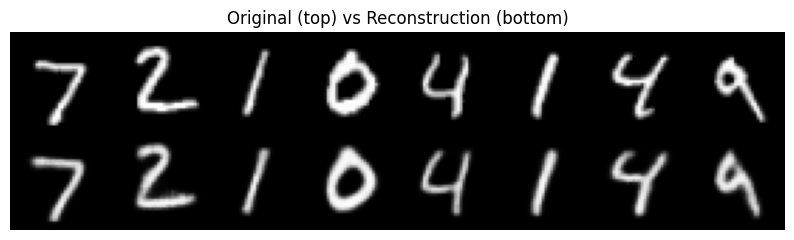

In [7]:
model.eval()
x, _ = next(iter(test_loader))
x = x[:8].to(device)

with torch.no_grad():
    recon, _, _ = model(x)

comparison = torch.cat([x.cpu(), recon.cpu()])

plt.figure(figsize=(10,4))
plt.imshow(np.transpose(utils.make_grid(comparison, nrow=8).numpy(), (1,2,0)))
plt.title("Original (top) vs Reconstruction (bottom)")
plt.axis("off")
plt.show()

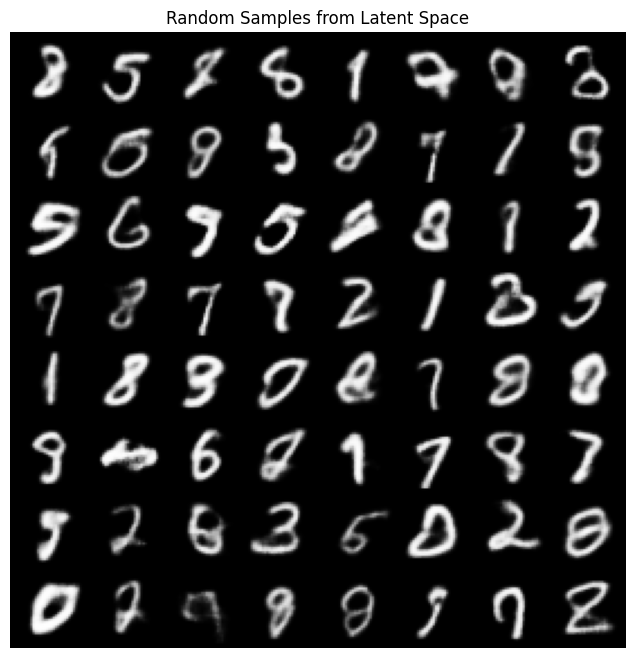

In [8]:
z = torch.randn(64, LATENT_DIM).to(device)

with torch.no_grad():
    samples = model.decode(z)

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(utils.make_grid(samples.cpu(), nrow=8).numpy(), (1,2,0)))
plt.title("Random Samples from Latent Space")
plt.axis("off")
plt.show()

Running t-SNE (this may take ~30 sec)...


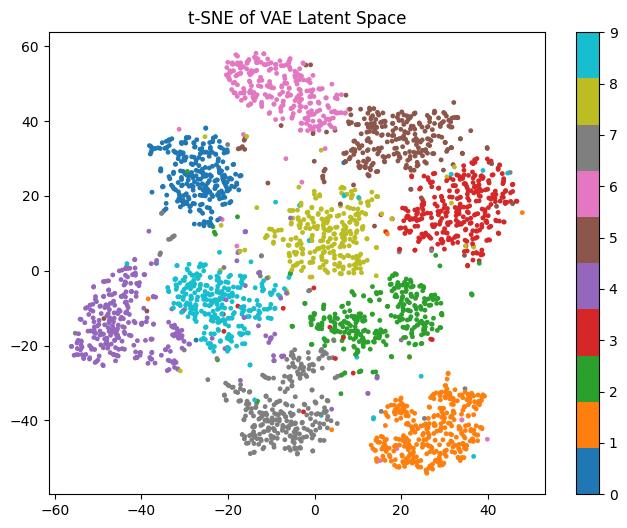

In [9]:
latents = []
labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, _ = model.encode(x)
        latents.append(mu.cpu().numpy())
        labels.append(y.numpy())

latents = np.concatenate(latents)
labels = np.concatenate(labels)

print("Running t-SNE (this may take ~30 sec)...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latents[:3000])

plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels[:3000], cmap="tab10", s=6)
plt.colorbar()
plt.title("t-SNE of VAE Latent Space")
plt.show()

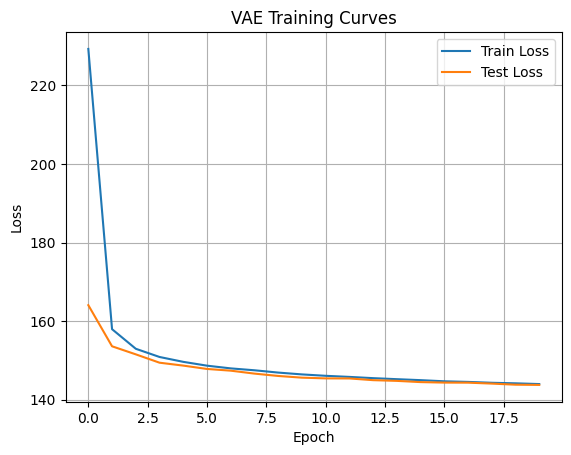

In [10]:
plt.plot(train_hist, label="Train Loss")
plt.plot(test_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Curves")
plt.legend()
plt.grid(True)
plt.show()